Data downloaded from https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from datetime import datetime

In [4]:
from datetime import timedelta

In [5]:
df = pd.read_csv('/share/data/willett-group/climate/data/Forest Segmented/Forest Segmented/meta_data.csv')

In [6]:
from PIL import Image

In [7]:
%%time
df['coverage'] = df['mask'].apply(lambda x: (np.array(Image.open('/share/data/willett-group/climate/data/Forest Segmented/Forest Segmented/masks/'+x))==0).mean())

CPU times: user 7.49 s, sys: 387 ms, total: 7.87 s
Wall time: 9.32 s


In [8]:
df['path'] = df['image']

<Axes: ylabel='Frequency'>

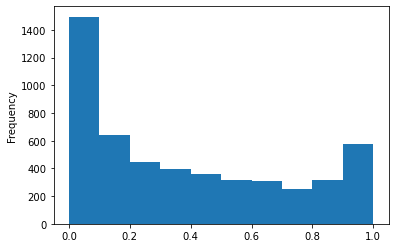

In [9]:
df["coverage"].plot.hist(density=False)

In [10]:
base_path = '/share/data/willett-group/climate/data/Forest Segmented/Forest Segmented/images/'

In [11]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_path = '/share/data/willett-group/climate/data/Forest Segmented/Forest Segmented/images/'):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(base_path+img_path)
        response = torch.tensor(self.dataframe.iloc[idx]['coverage'], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, response
# Custom transform function
def convert_grayscale_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

# Transforms
transform = transforms.Compose([
    transforms.Lambda(convert_grayscale_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform, base_path=base_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

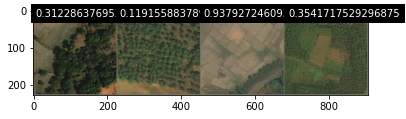

In [12]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Modified imshow function with label positions
def imshow(img, labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], num_images_per_row=4):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # Get the height and width of the image grid
    grid_height, grid_width, _ = img.shape

    # Height of each image
    img_height = grid_height // (len(labels) // num_images_per_row)

    # Display labels
    for idx, label in enumerate(labels):
        x = (idx % num_images_per_row) * img_height
        y = (idx // num_images_per_row) * img_height
        plt.text(x + 5, y + 15, label, color='white', backgroundcolor='black')

    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

# Convert labels to a list of strings if necessary
labels = [str(label.item()) for label in labels]

imshow(out, labels, num_images_per_row=4)


In [13]:
# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [14]:
%%time
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

model_features = torch.nn.Sequential(*(list(model.children())[:-1]))

for param in model_features.parameters():
    param.requires_grad = False

model_features.to('cuda')

CPU times: user 4.11 s, sys: 3.38 s, total: 7.5 s
Wall time: 9.18 s


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
model.fc.in_features

512

In [16]:
%%time
model_features(images.to('cuda')).squeeze().cpu().numpy().shape

CPU times: user 977 ms, sys: 701 ms, total: 1.68 s
Wall time: 1.98 s


(4, 512)

In [17]:
X = np.zeros((df.shape[0], model.fc.in_features))
y = np.zeros((df.shape[0]))

In [18]:
X.shape

(5108, 512)

In [19]:
y.shape

(5108,)

In [20]:
from tqdm import tqdm

In [21]:
i = 0
for images, labels in tqdm(dataloader):
    num_entries = images.shape[0]

    X[i:(i+num_entries)] = model_features(images.to('cuda')).squeeze().cpu().numpy()

    y[i:(i+num_entries)] = labels.numpy()

    i = i + num_entries

100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


In [22]:
y

array([0.7918396 , 0.99668884, 0.22264099, ..., 0.1421814 , 0.77685547,
       0.9670105 ])

In [23]:
np.save('/share/data/willett-group/climate/data/Forest Segmented/y.npy', y)

In [24]:
np.save('/share/data/willett-group/climate/data/Forest Segmented/X.npy', X)

In [25]:
y.mean()

0.38155734809750025

In [26]:
np.quantile(y, [0.05, 0.95])

array([0.00575867, 0.9745079 ])

In [27]:
1/0.4

2.5